<img src="images/arm_logo.png" width=500 alt="ARM Logo"></img>

# Bankhead National Forest - Evaluation of RadClss

## Overview

The Extracted Radar Columns and In-Situ Sensors (RadClss) Value-Added Product (VAP) is
a dataset containing in-situ ground observations matched to CSAPR-2 radar columns above ARM Mobile Facility (AMF-3) supplemental sites of interest. 

RadCLss is intended to provide a dataset for algorthim development and validation of precipitation retrievals.

This notebook utilizes months of processed RadCLss data for an evaluation of the precipitation fields within CMAC 

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf) | Helpful | Familiarity with metadata structure |
| [GeoPandas](https://geopandas.org/en/stable/docs.html) | Necessary | Familiarity with Geospatial Plotting|
| [Py-ART / Radar Foundations](https://projectpythia.org/radar-cookbook/README) | Necessary | Basics of Weather Radar | 

- **Time to learn**: 30 minutes

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import glob
import datetime

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import dask
import cartopy.crs as ccrs

from math import atan2 as atan2
from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.img_tiles import OSM
from matplotlib.transforms import offset_copy
from dask.distributed import Client, LocalCluster
from metpy.plots import USCOUNTIES
from scipy.stats import linregress

import act
import pyart

dask.config.set({'logging.distributed': 'error'})


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Define Processing Variables

In [ ]:
# Define the directory where the BNF RadCLss files are located.
RADCLSS_DIR = os.getenv("BNF_RADCLSS_DIR")
MET_M1_DIR = os.getenv("BNF_INSITU_DIR") + "bnfmetM1.b1/"

## Locate and Open the In-Situ Data and Processed RadCLss Data

In [ ]:
met_list = sorted(glob.glob(MET_M1_DIR + "bnfmetM1.b1.*"))

'/nfs/gce/globalscratch/obrienj/bnf-insitu/bnfmetM1.b1/bnfmetM1.b1.20250121.000000.cdf'

In [4]:
ds_met = xr.open_mfdataset(met_list)

In [ ]:
# With the user defined RADAR_DIR, grab all the XPRECIPRADAR CMAC files for the defined DATE
file_list = sorted(glob.glob(RADCLSS_DIR + 'bnfcsapr2radclssS3*.nc'))

'/nfs/gce/globalscratch/obrienj/bnf-radclss-v5/bnfcsapr2radclssS3.c2.20250321.000000.nc'

In [6]:
ds = xr.open_mfdataset(file_list)

In [7]:
ds.load()

<xarray.Dataset> Size: 364MB
Dimensions:                                                (time: 15196,
                                                            station: 6,
                                                            height: 32)
Coordinates:
  * time                                                   (time) datetime64[ns] 122kB ...
  * height                                                 (height) int64 256B ...
  * station                                                (station) <U3 72B ...
Data variables: (12/67)
    base_time                                              (time) datetime64[ns] 122kB ...
    time_offset                                            (time) datetime64[ns] 122kB ...
    gate_time                                              (time, station) datetime64[ns] 729kB ...
    attenuation_corrected_differential_reflectivity        (time, height, station) float64 23MB ...
    attenuation_corrected_differential_reflectivity_lag_1  (time, height, station) float64 23MB ...
    attenuation_corrected_reflectivity_h                   (time, height, station) float64 23MB ...
    ...                                                     ...
    wxt_temp_mean                                          (time, station) float64 729kB ...
    wxt_precip_rate_mean                                   (time, station) float64 729kB ...
    wxt_cumul_precip                                       (time, station) float64 729kB ...
    lat                                                    (time, station) float64 729kB ...
    lon                                                    (time, station) float64 729kB ...
    alt                                                    (time, station) int64 729kB ...
Attributes: (12/22)
    command_line:          python bnf_radclss.py --serial True --array True
    Conventions:           CF/Radial instrument_parameters ARM-1.3
    process_version:       
    dod_version:           csapr2radclss-c2-1.28
    input_datastreams:     ['bnfcsapr2cmacS3.c1', 'bnfmetM1.b1', 'bnfmetS20.b...
    site_id:               bnf
    ...                    ...
    version:               1.0
    vap_name:              
    known_issues:          False phidp jumps in insect regions. Still uses ol...
    field_names:           attenuation_corrected_differential_reflectivity, a...
    source:                Atmospheric Radiation Measurement (ARM) program C-...
    history:               created by user jrobrien on machine cumulus.ccs.or...

## MET and RadCLss - Rain Rate Time Series

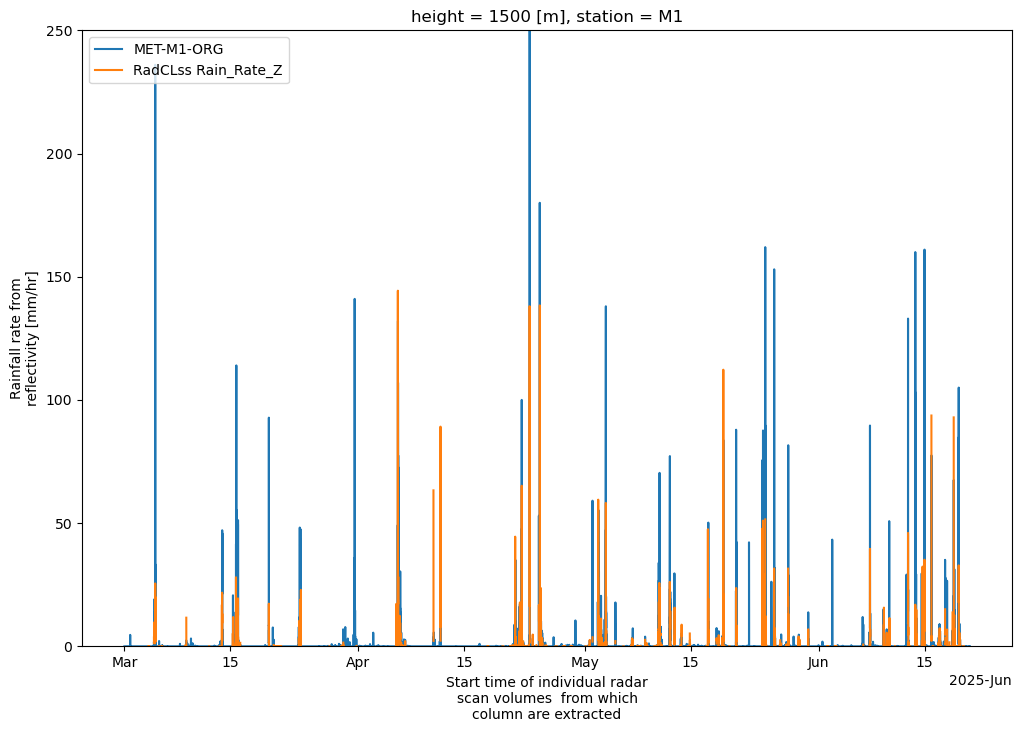

In [20]:
fig, axs = plt.subplots(1, 1, figsize=[12, 8])

ds_met.sel(time=slice("2025-03-01T00:00:00", "2025-06-20T23:59:59")).org_precip_rate_mean.plot(ax=axs, label="MET-M1-ORG")
ds.sel(time=slice("2025-03-01T00:00:00", "2025-06-20T23:59:59")).sel(station="M1").sel(height=1600, method="nearest").rain_rate_Z.plot(ax=axs, label="RadCLss Rain_Rate_Z")

##ds_met.sel(time=slice("2025-04-06T06:30:00", "2025-04-06T07:59:59")).org_precip_rate_mean.plot(ax=axs, label="MET-ORG")
##ds.sel(time=slice("2025-04-06T06:30:00", "2025-04-06T07:59:59")).sel(station="M1").sel(height=1000, method="nearest").rain_rate_Z.plot(ax=axs, label="RadCLss Rain_Rate_Z")
axs.set_ylim([0, 250])
axs.legend(loc='upper left')

## CMAC - LDQUANTS: Rain Rate Comparison

M1 rain_rate_Z
S30 rain_rate_Z
M1 rain_rate_Kdp
S30 rain_rate_Kdp
M1 rain_rate_A
S30 rain_rate_A


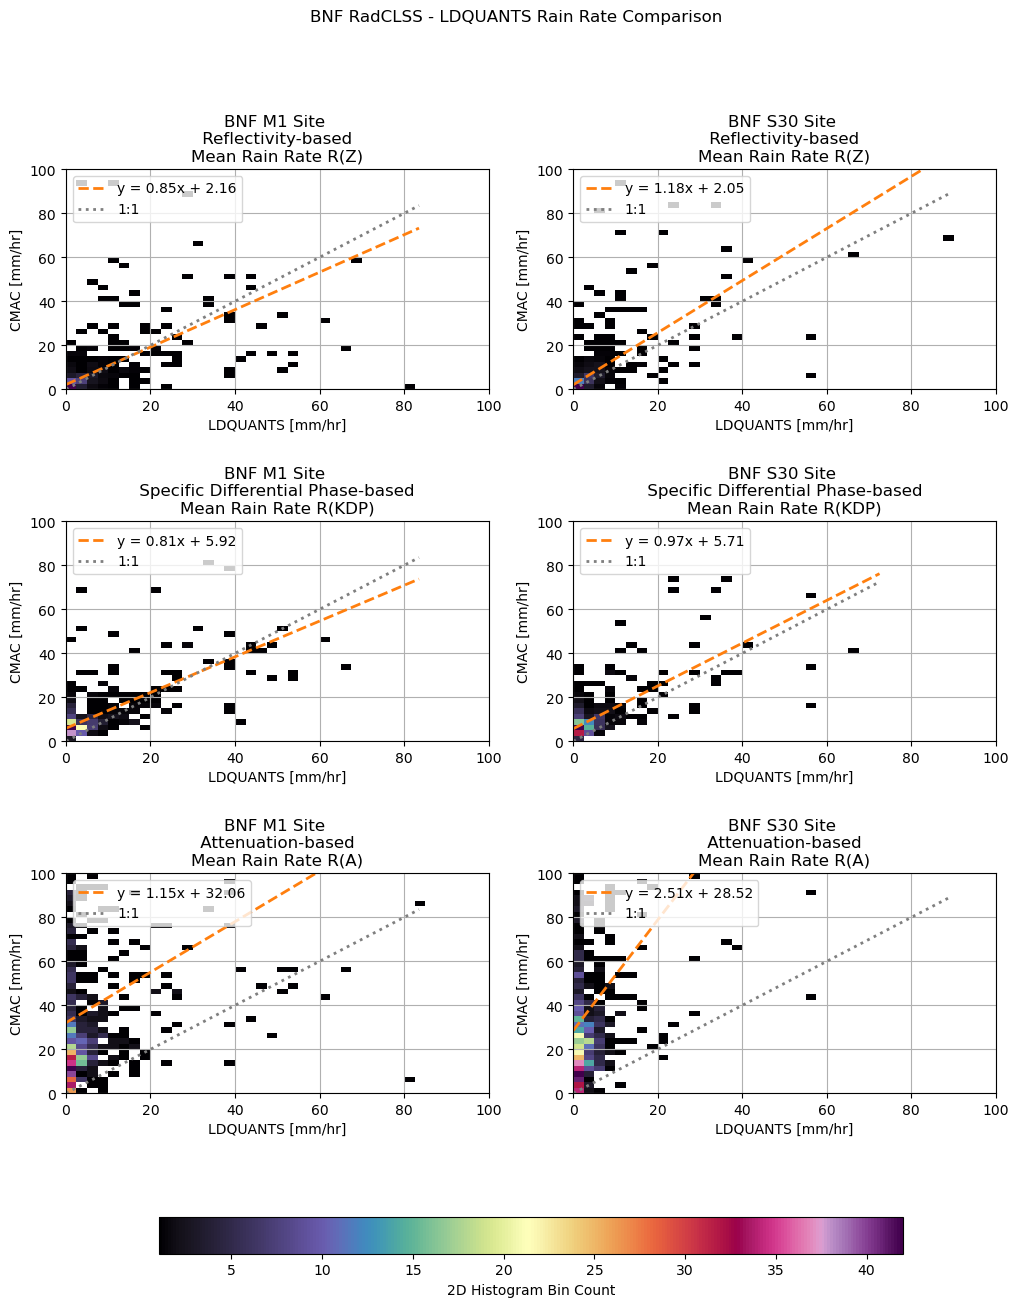

In [15]:
fig, axarr = plt.subplots(3, 2, figsize=[12, 16])
plt.subplots_adjust(wspace=0.2, hspace=0.6)

fig.suptitle("BNF RadCLSS - LDQUANTS Rain Rate Comparison")

ld_parms = {"rain_rate_Z" : [0, 100, "Reflectivity-based \nMean Rain Rate R(Z)"], 
            "rain_rate_Kdp" : [0, 100, "Specific Differential Phase-based \nMean Rain Rate R(KDP)"],
            "rain_rate_A" :  [0, 100, "Attenuation-based \nMean Rain Rate R(A)"],
}

i = 0
for parm in ld_parms:
    j = 0
    for site in ds.station.data:
        if site in ["M1", "S30"]:
            print(site, parm)
            if parm != "rain_rate_A":
                mask = (
                        np.isfinite(ds["ldquants_rain_rate"].sel(station=site).data) & 
                        np.isfinite(ds[parm].sel(station=site).sel(height=1500, method="nearest").data) &
                        (ds["ldquants_rain_rate"].sel(station=site).data > 0.01) &
                        (ds[parm].sel(station=site).sel(height=1500, method="nearest").data > 0.01)
                    )
            else:
                mask = (
                        np.isfinite(ds["ldquants_rain_rate"].sel(station=site).data) & 
                        np.isfinite(ds[parm].sel(station=site).sel(height=1500, method="nearest").data) &
                        (ds["ldquants_rain_rate"].sel(station=site).data > 0.01)
                    )

            h = axarr[i, j].hist2d(ds["ldquants_rain_rate"].sel(station=site).data[mask],
                                   ds[parm].sel(station=site).sel(height=1500, method="nearest").data[mask],
                                   bins=[40, 40],
                                   range=[[0, 100], [0, 100]],
                                   cmap="ChaseSpectral",
                                   cmin=1,
            )

            axarr[i, j].set_title(f"BNF {site} Site \n {ld_parms[parm][2]}")
            axarr[i, j].set_xlim([0, 100])
            axarr[i, j].set_ylim([0, 100])
            axarr[i, j].set_xlabel("LDQUANTS [mm/hr]")
            axarr[i, j].set_ylabel("CMAC [mm/hr]")
            axarr[i, j].grid(True)

            # calculate a linear regression
            slope, intercept, r_value, p_value, std_err = linregress(ds["ldquants_rain_rate"].sel(station=site).data[mask],
                                                                     ds[parm].sel(station=site).sel(height=1500, method="nearest").data[mask])
            x_fit = np.linspace(ds["ldquants_rain_rate"].sel(station=site).data[mask].min(), 
                                ds["ldquants_rain_rate"].sel(station=site).data[mask].max(), 
                                100)
            y_fit = slope * x_fit + intercept
            # plot the linear regression
            axarr[i, j].plot(x_fit, y_fit, color='tab:orange', linestyle='--', linewidth=2, label=f"y = {slope:.2f}x + {intercept:.2f}")
            # Optional: 1:1 line
            axarr[i, j].plot(x_fit, x_fit, color='tab:gray', linestyle=':', label='1:1', linewidth=2)
            axarr[i, j].legend(loc='upper left')

            j += 1
    i += 1

# Colorbar for histogram bin counts
cbar = fig.colorbar(h[3], ax=axarr, location='bottom', shrink=0.8, pad=0.1)
cbar.set_label("2D Histogram Bin Count")

## CMAC - LDQUANTS: Radar Parameters Comparison

M1 ldquants_reflectivity_factor_cband20c
S30 ldquants_reflectivity_factor_cband20c
M1 ldquants_differential_reflectivity_cband20c
S30 ldquants_differential_reflectivity_cband20c
M1 ldquants_specific_differential_phase_cband20c
S30 ldquants_specific_differential_phase_cband20c


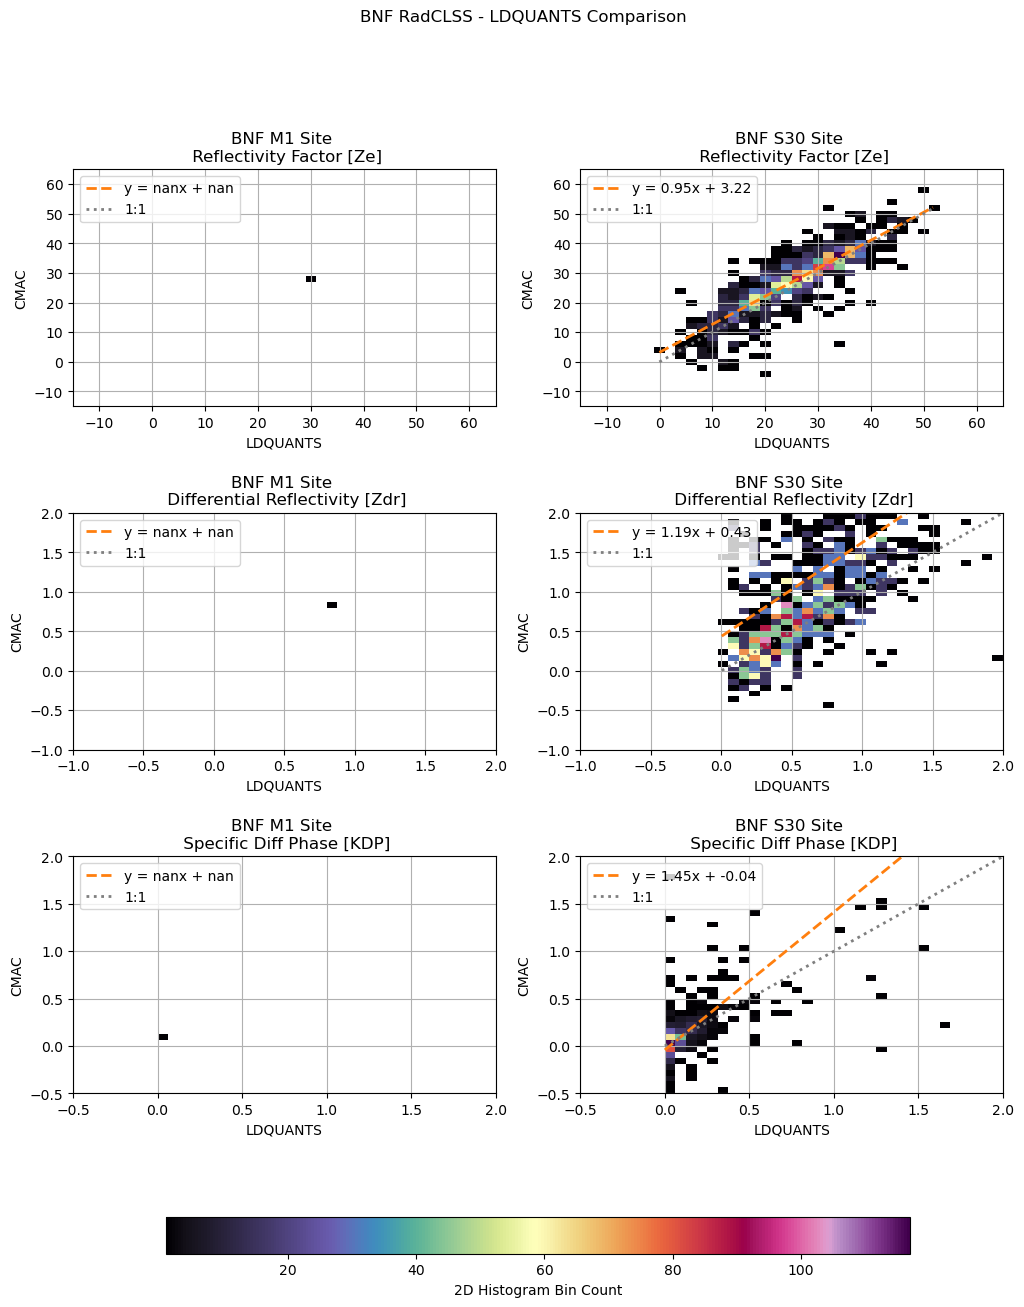

In [10]:
fig, axarr = plt.subplots(3, 2, figsize=[12, 16])
plt.subplots_adjust(wspace=0.2, hspace=0.45)

fig.suptitle("BNF RadCLSS - LDQUANTS Comparison")

ld_parms = {
    "ldquants_reflectivity_factor_cband20c": ["corrected_reflectivity", -15, 65, "Reflectivity Factor [Ze]"], 
    "ldquants_differential_reflectivity_cband20c": ["corrected_differential_reflectivity", -1, 2, "Differential Reflectivity [Zdr]"],
    "ldquants_specific_differential_phase_cband20c": ["corrected_specific_diff_phase", -0.5, 2, "Specific Diff Phase [KDP]"],
}

i = 0
for parm in ld_parms:
    j = 0
    for site in ds.station.data:
        if site in ["M1", "S30"]:
            print(site, parm)
            if parm == "ldquants_specific_differential_phase_cband20c":
                mask = (
                    np.isfinite(ds["ldquants_specific_differential_phase_cband20c"].sel(station=site).data) & 
                    np.isfinite(ds["corrected_specific_diff_phase"].sel(station=site).sel(height=1000).data) &
                    (ds["corrected_specific_diff_phase"].sel(station=site).sel(height=1000).data > -10) &
                    (ds["corrected_specific_diff_phase"].sel(station=site).sel(height=1000).data < 10)
                )
            elif parm == "ldquants_differential_reflectivity_cband20c":
                mask = (
                    np.isfinite(ds["ldquants_differential_reflectivity_cband20c"].sel(station=site).data) & 
                    np.isfinite(ds["corrected_differential_reflectivity"].sel(station=site).sel(height=1000).data) &
                    (ds["ldquants_differential_reflectivity_cband20c"].sel(station=site).data > -2)
                )
            else:
                mask = (
                    np.isfinite(ds[parm].sel(station=site).data) & 
                    np.isfinite(ds[ld_parms[parm][0]].sel(station=site).sel(height=1000, method="nearest").data)
                )

            h = axarr[i, j].hist2d(ds[parm].sel(station=site).data[mask],
                                   ds[ld_parms[parm][0]].sel(station=site).sel(height=1000, method="nearest").data[mask],
                                   bins=[40, 40],
                                   range=[[ld_parms[parm][1], ld_parms[parm][2]], [ld_parms[parm][1], ld_parms[parm][2]]],
                                   cmap="ChaseSpectral",
                                   cmin=1,
            )

            axarr[i, j].set_title(f"BNF {site} Site \n {ld_parms[parm][3]}")
            axarr[i, j].set_xlim([ld_parms[parm][1], ld_parms[parm][2]])
            axarr[i, j].set_ylim([ld_parms[parm][1], ld_parms[parm][2]])
            axarr[i, j].set_xlabel("LDQUANTS")
            axarr[i, j].set_ylabel("CMAC")
            axarr[i, j].grid(True)

            # calculate a linear regression
            slope, intercept, r_value, p_value, std_err = linregress(ds[parm].sel(station=site).data[mask],
                                                                     ds[ld_parms[parm][0]].sel(station=site).sel(height=1000, method="nearest").data[mask])
            x_fit = np.linspace(ds[parm].sel(station=site).data[mask].min(), 
                                ds[parm].sel(station=site).data[mask].max(), 
                                100)
            y_fit = slope * x_fit + intercept
            # plot the linear regression
            axarr[i, j].plot(x_fit, y_fit, color='tab:orange', linestyle='--', linewidth=2, label=f"y = {slope:.2f}x + {intercept:.2f}")
            # Optional: 1:1 line
            axarr[i, j].plot(x_fit, x_fit, color='tab:gray', linestyle=':', label='1:1', linewidth=2)
            axarr[i, j].legend(loc='upper left')

            j += 1
    i += 1

# Colorbar for histogram bin counts
cbar = fig.colorbar(h[3], ax=axarr, location='bottom', shrink=0.8, pad=0.1)
cbar.set_label("2D Histogram Bin Count")


### LDQUANTS Comparison with Weights

M1 ldquants_reflectivity_factor_cband20c
S30 ldquants_reflectivity_factor_cband20c
M1 ldquants_differential_reflectivity_cband20c
S30 ldquants_differential_reflectivity_cband20c
M1 ldquants_specific_differential_phase_cband20c
S30 ldquants_specific_differential_phase_cband20c


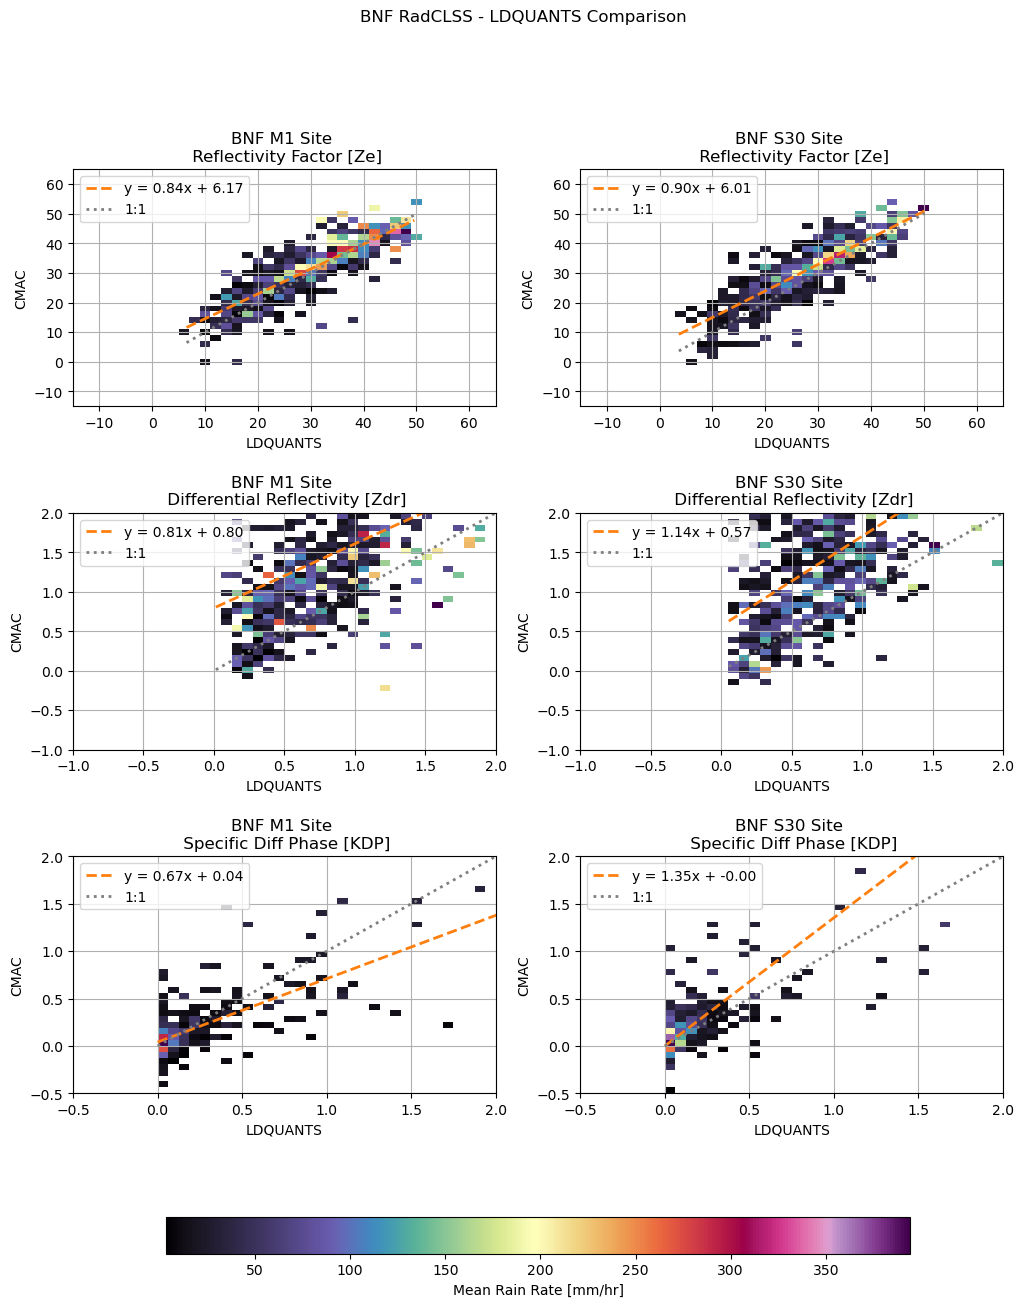

In [11]:
fig, axarr = plt.subplots(3, 2, figsize=[12, 16])
plt.subplots_adjust(wspace=0.2, hspace=0.45)

fig.suptitle("BNF RadCLSS - LDQUANTS Comparison")

ld_parms = {
    "ldquants_reflectivity_factor_cband20c": ["corrected_reflectivity", -15, 65, "Reflectivity Factor [Ze]"], 
    "ldquants_differential_reflectivity_cband20c": ["corrected_differential_reflectivity", -1, 2, "Differential Reflectivity [Zdr]"],
    "ldquants_specific_differential_phase_cband20c": ["corrected_specific_diff_phase", -0.5, 2, "Specific Diff Phase [KDP]"],
}

i = 0
for parm in ld_parms:
    j = 0
    for site in ds.station.data:
        if site in ["M1", "S30"]:
            print(site, parm)
            z = ds.sel(station=site).sel(height=1500).rain_rate_Kdp.values.flatten()
            if parm == "ldquants_specific_differential_phase_cband20c":
                mask = (
                    np.isfinite(ds["ldquants_specific_differential_phase_cband20c"].sel(station=site).data) & 
                    np.isfinite(ds["corrected_specific_diff_phase"].sel(station=site).sel(height=1500).data) &
                    (ds["corrected_specific_diff_phase"].sel(station=site).sel(height=1500).data > -10) &
                    (ds["corrected_specific_diff_phase"].sel(station=site).sel(height=1500).data < 10) &
                    np.isfinite(z)
                )
            elif parm == "ldquants_differential_reflectivity_cband20c":
                mask = (
                    np.isfinite(ds["ldquants_differential_reflectivity_cband20c"].sel(station=site).data) & 
                    np.isfinite(ds["corrected_differential_reflectivity"].sel(station=site).sel(height=1500).data) &
                    (ds["ldquants_differential_reflectivity_cband20c"].sel(station=site).data > -2) &
                    np.isfinite(z)
                )
            else:
                mask = (
                    np.isfinite(ds[parm].sel(station=site).data) & 
                    np.isfinite(ds[ld_parms[parm][0]].sel(station=site).sel(height=1500, method="nearest").data) &
                    np.isfinite(z)
                )

            h = axarr[i, j].hist2d(ds[parm].sel(station=site).data[mask],
                                   ds[ld_parms[parm][0]].sel(station=site).sel(height=1500, method="nearest").data[mask],
                                   weights=z[mask],
                                   bins=[40, 40],
                                   range=[[ld_parms[parm][1], ld_parms[parm][2]], [ld_parms[parm][1], ld_parms[parm][2]]],
                                   cmap="ChaseSpectral",
                                   cmin=1,
            )

            axarr[i, j].set_title(f"BNF {site} Site \n {ld_parms[parm][3]}")
            axarr[i, j].set_xlim([ld_parms[parm][1], ld_parms[parm][2]])
            axarr[i, j].set_ylim([ld_parms[parm][1], ld_parms[parm][2]])
            axarr[i, j].set_xlabel("LDQUANTS")
            axarr[i, j].set_ylabel("CMAC")
            axarr[i, j].grid(True)

            # calculate a linear regression
            slope, intercept, r_value, p_value, std_err = linregress(ds[parm].sel(station=site).data[mask],
                                                                     ds[ld_parms[parm][0]].sel(station=site).sel(height=1500, method="nearest").data[mask])
            x_fit = np.linspace(ds[parm].sel(station=site).data[mask].min(), 
                                ds[parm].sel(station=site).data[mask].max(), 
                                100)
            y_fit = slope * x_fit + intercept
            # plot the linear regression
            axarr[i, j].plot(x_fit, y_fit, color='tab:orange', linestyle='--', linewidth=2, label=f"y = {slope:.2f}x + {intercept:.2f}")
            # Optional: 1:1 line
            axarr[i, j].plot(x_fit, x_fit, color='tab:gray', linestyle=':', label='1:1', linewidth=2)
            axarr[i, j].legend(loc='upper left')

            j += 1
    i += 1

# Colorbar for histogram bin counts
cbar = fig.colorbar(h[3], ax=axarr, location='bottom', shrink=0.8, pad=0.1)
cbar.set_label("Mean Rain Rate [mm/hr]")

ValueError: Inputs must not be empty.

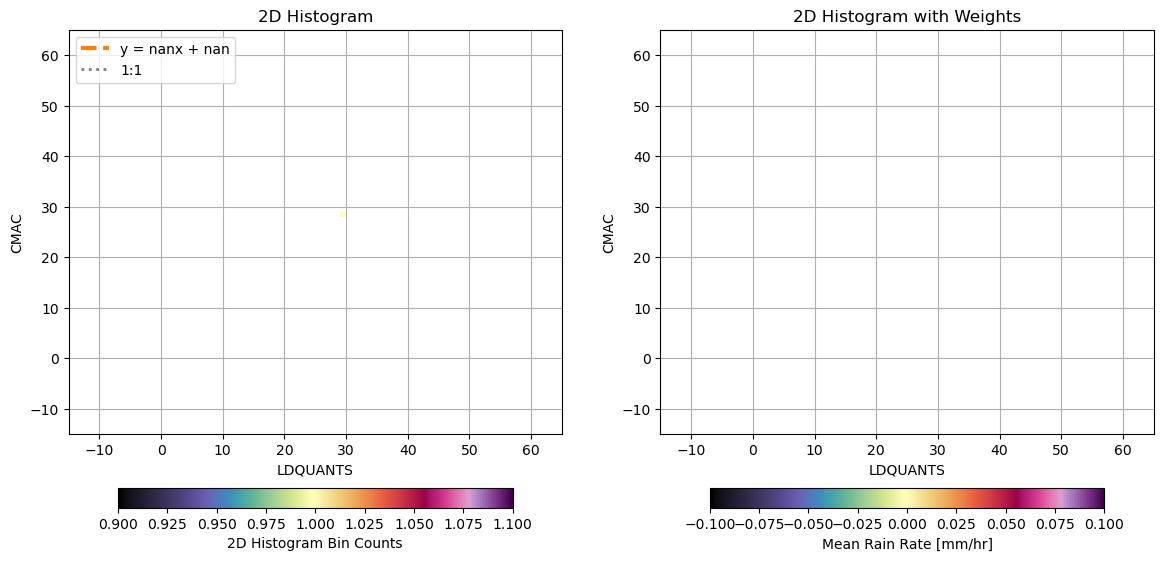

In [12]:
from scipy.stats import linregress

# ------------------------------
# A)-- 2D Histogram with Counts
# ------------------------------
mask = np.isfinite(ds["ldquants_reflectivity_factor_cband20c"].sel(station="M1").data) & np.isfinite(ds['corrected_reflectivity'].sel(station="M1").sel(height=1000).data)

fig, axarr = plt.subplots(1, 2, figsize=[14, 7])

h = axarr[0].hist2d(ds["ldquants_reflectivity_factor_cband20c"].sel(station="M1").data[mask],
                    ds['corrected_reflectivity'].sel(station="M1").sel(height=1000).data[mask],
                    bins=[80, 80],
                    range=[[-15, 65], [-15, 65]],
                    cmap="ChaseSpectral",
                    cmin=1
)

axarr[0].set_title("2D Histogram")
axarr[0].set_xlim([-15, 65])
axarr[0].set_ylim([-15, 65])
axarr[0].set_xlabel("LDQUANTS")
axarr[0].set_ylabel("CMAC")
axarr[0].grid(True)
fig.colorbar(h[3], ax=axarr[0], location="bottom", shrink=0.8, pad=0.1, label="2D Histogram Bin Counts")

# calculate a linear regression
slope, intercept, r_value, p_value, std_err = linregress(ds["ldquants_reflectivity_factor_cband20c"].sel(station="M1").data[mask],
                                                         ds['corrected_reflectivity'].sel(station="M1").sel(height=1000).data[mask])
x_fit = np.linspace(ds["ldquants_reflectivity_factor_cband20c"].sel(station="M1").data[mask].min(), 
                    ds["ldquants_reflectivity_factor_cband20c"].sel(station="M1").data[mask].max(), 
                    100)
y_fit = slope * x_fit + intercept
# plot the linear regression
axarr[0].plot(x_fit, y_fit, color='tab:orange', linestyle='--', linewidth=3, label=f"y = {slope:.2f}x + {intercept:.2f}")
# Optional: 1:1 line
axarr[0].plot(x_fit, x_fit, color='tab:gray', linestyle=':', label='1:1', linewidth=2)
axarr[0].legend(loc='upper left')

#----------------------------
# B) - Weighted 2D Histogram
#----------------------------

z = ds.sel(station=site).sel(height=1500).rain_rate_Kdp.values.flatten()
z_mask = np.isfinite(ds["ldquants_reflectivity_factor_cband20c"].sel(station="M1").data) & np.isfinite(ds['corrected_reflectivity'].sel(station="M1").sel(height=1000).data) & np.isfinite(z)

h = axarr[1].hist2d(ds["ldquants_reflectivity_factor_cband20c"].sel(station="M1").data[mask],
                    ds['corrected_reflectivity'].sel(station="M1").sel(height=1500).data[mask],
                    weights=z[mask],
                    bins=[80, 80],
                    range=[[-15, 65], [-15, 65]],
                    cmap="ChaseSpectral",
                    cmin=1,
)

axarr[1].set_title("2D Histogram with Weights")
axarr[1].set_xlim([-15, 65])
axarr[1].set_ylim([-15, 65])
axarr[1].set_xlabel("LDQUANTS")
axarr[1].set_ylabel("CMAC")
axarr[1].grid(True)
fig.colorbar(h[3], ax=axarr[1], location="bottom", shrink=0.8, pad=0.1, label="Mean Rain Rate [mm/hr]")

# calculate a linear regression
slope, intercept, r_value, p_value, std_err = linregress(ds["ldquants_reflectivity_factor_cband20c"].sel(station="M1").data[z_mask],
                                                         ds['corrected_reflectivity'].sel(station="M1").sel(height=1000).data[z_mask])
x_fit = np.linspace(ds["ldquants_reflectivity_factor_cband20c"].sel(station="M1").data[z_mask].min(), 
                    ds["ldquants_reflectivity_factor_cband20c"].sel(station="M1").data[z_mask].max(), 
                    100)
y_fit = slope * x_fit + intercept
# plot the linear regression
axarr[1].plot(x_fit, y_fit, color='tab:orange', linestyle='--', linewidth=3, label=f"y = {slope:.2f}x + {intercept:.2f}")
# Optional: 1:1 line
axarr[1].plot(x_fit, x_fit, color='tab:gray', linestyle=':', label='1:1', linewidth=2)
axarr[1].legend(loc='upper left')

In [ ]:
ds

<xarray.Dataset> Size: 198MB
Dimensions:                                                (time: 8250,
                                                            station: 6,
                                                            height: 32)
Coordinates:
  * time                                                   (time) datetime64[ns] 66kB ...
  * height                                                 (height) int64 256B ...
  * station                                                (station) <U3 72B ...
Data variables: (12/67)
    base_time                                              (time) datetime64[ns] 66kB ...
    time_offset                                            (time) datetime64[ns] 66kB ...
    gate_time                                              (time, station) datetime64[ns] 396kB ...
    attenuation_corrected_differential_reflectivity        (time, height, station) float64 13MB ...
    attenuation_corrected_differential_reflectivity_lag_1  (time, height, station) float64 13MB ...
    attenuation_corrected_reflectivity_h                   (time, height, station) float64 13MB ...
    ...                                                     ...
    wxt_temp_mean                                          (time, station) float64 396kB ...
    wxt_precip_rate_mean                                   (time, station) float64 396kB ...
    wxt_cumul_precip                                       (time, station) float64 396kB ...
    lat                                                    (time, station) float64 396kB ...
    lon                                                    (time, station) float64 396kB ...
    alt                                                    (time, station) int64 396kB ...
Attributes: (12/22)
    command_line:          python bnf_radclss.py --serial True --array True
    Conventions:           CF/Radial instrument_parameters ARM-1.3
    process_version:       
    dod_version:           csapr2radclss-c2-1.28
    input_datastreams:     ['bnfcsapr2cmacS3.c1', 'bnfmetM1.b1', 'bnfmetS20.b...
    site_id:               bnf
    ...                    ...
    version:               1.0
    vap_name:              
    known_issues:          False phidp jumps in insect regions. Still uses ol...
    field_names:           attenuation_corrected_differential_reflectivity, a...
    source:                Atmospheric Radiation Measurement (ARM) program C-...
    history:               created by user jrobrien on machine cumulus.ccs.or...

 ## Z-R Fit Analysis

In [ ]:
def linear_regress_fit(parm_y, rain_rate):
    """
    calculate the linear regression for the specific radar variable vs rain rate
    """
    # Generate the mask
    ld_mask = (np.isfinite(parm_y) & 
               np.isfinite(rain_rate) &
               (rain_rate > 0.01)
    )
    
    Z_linear = 10**(parm_y[ld_mask] / 10) # Z in mm^6 m^-3
    log_Z = np.log10(Z_linear) # Take log10 of Z
    log_R = np.log10(rain_rate[ld_mask]) # Take log10 of rain rate

    coefficients_zr = np.polyfit(log_R, log_Z, 1) # Linear fit: log(Z) = b*log(R) + log(a)
    print(f"coefficients_zr (raw from np.polyfit): {coefficients_zr}")
    b_coefficient = coefficients_zr[0] # Slope
    log_a_coefficient = coefficients_zr[1] # Intercept
    a_coefficient = 10**log_a_coefficient # Convert to a

    print(f"Relationship for C-band (from LDQUANTS or CMAC data):")
    print(f"Z = {a_coefficient:.2f} * R**{b_coefficient:.2f}") # Z = a * R^b

    return a_coefficient, b_coefficient

coefficients_zr (raw from np.polyfit): [1.43255524 2.31926487]
Relationship for C-band (from LDQUANTS or CMAC data):
Z = 208.58 * R**1.43
coefficients_zr (raw from np.polyfit): [1.38843947 2.56970693]
Relationship for C-band (from LDQUANTS or CMAC data):
Z = 371.28 * R**1.39


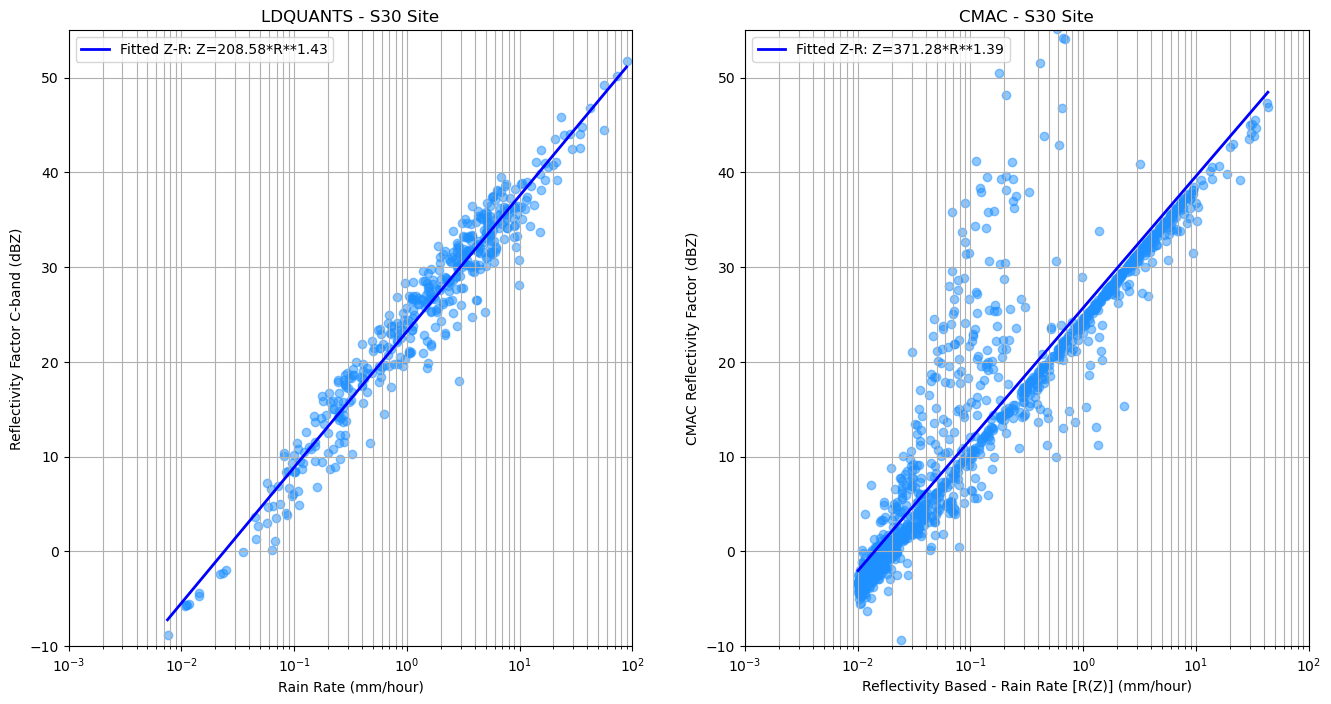

In [ ]:
# Need to mask the rain rates
cmac_mask = (np.isfinite(ds.sel(station="S30").sel(height=1500, method="nearest").rain_rate_Z.data) & 
             np.isfinite(ds.sel(station="S30").sel(height=1500, method="nearest").corrected_reflectivity.data) &
             (ds.sel(station="S30").sel(height=1500, method="nearest").rain_rate_Z.data > 0.01)
)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].scatter(ds.sel(station="S30").ldquants_rain_rate.data, 
               ds.sel(station="S30").ldquants_reflectivity_factor_cband20c.data, 
               alpha=0.5, 
               color='dodgerblue')
axs[0].set_xlabel('Rain Rate (mm/hour)')
axs[0].set_ylabel('Reflectivity Factor C-band (dBZ)')
axs[0].set_xscale('log') # Logarithmic scale for rain rate
axs[0].set_yscale('linear')
axs[0].set_ylim([-10, 55])
axs[0].set_xlim([1e-3, 1e2])
axs[0].set_title("LDQUANTS - S30 Site")
axs[0].grid(True, which="both", ls="-")
# Add the fitted Z-R line
rain_rate_line = np.logspace(np.log10(np.nanmin(ds.sel(station="S30").ldquants_rain_rate.data)), np.log10(np.nanmax(ds.sel(station="S30").ldquants_rain_rate.data)), 100)
a_coeff, b_coeff = linear_regress_fit(ds["ldquants_reflectivity_factor_cband20c"].sel(station="S30").data,
                                      ds["ldquants_rain_rate"].sel(station="S30").data)
Z_linear_line = a_coeff * (rain_rate_line**b_coeff)
reflectivity_dbz_line = 10 * np.log10(Z_linear_line)
axs[0].plot(rain_rate_line, reflectivity_dbz_line, color='blue', linewidth=2, label=f'Fitted Z-R: Z={a_coeff:.2f}*R**{b_coeff:.2f}')
axs[0].legend(loc="upper left")

axs[1].scatter(ds.sel(station="S30").sel(height=1500, method="nearest").rain_rate_Z.data[cmac_mask], 
               ds.sel(station="S30").sel(height=1500, method="nearest").corrected_reflectivity.data[cmac_mask], 
               alpha=0.5, 
               color='dodgerblue')
axs[1].set_xlabel('Reflectivity Based - Rain Rate [R(Z)] (mm/hour)')
axs[1].set_ylabel('CMAC Reflectivity Factor (dBZ)')
axs[1].set_xscale('log') # Logarithmic scale for rain rate
axs[1].set_yscale('linear')
axs[1].set_ylim([-10, 55])
axs[1].set_xlim([1e-3, 1e2])
axs[1].set_title("CMAC - S30 Site")
axs[1].grid(True, which="both", ls="-")
rain_rate_line_c = np.logspace(np.log10(np.nanmin(ds.sel(station="S30").sel(height=1500, method="nearest").rain_rate_Z.data[cmac_mask])), 
                               np.log10(np.nanmax(ds.sel(station="S30").sel(height=1500, method="nearest").rain_rate_Z.data[cmac_mask])), 
                               100)
a_coeff_c, b_coeff_c = linear_regress_fit(ds.sel(station="S30").sel(height=1500, method="nearest").corrected_reflectivity.data[cmac_mask],
                                          ds.sel(station="S30").sel(height=1500, method="nearest").rain_rate_Z.data[cmac_mask])
Z_linear_line_c = a_coeff_c * (rain_rate_line_c**b_coeff_c)
reflectivity_dbz_line_c = 10 * np.log10(Z_linear_line_c)
axs[1].plot(rain_rate_line_c, reflectivity_dbz_line_c, color='blue', linewidth=2, label=f'Fitted Z-R: Z={a_coeff_c:.2f}*R**{b_coeff_c:.2f}')
axs[1].legend(loc="upper left")

plt.legend()
plt.show()

## References

### Surface Meteorological Instrumentation (MET)
- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) **(M1)**.
Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, Supplemental facility at
Courtland **(S20)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, Supplemental facility at
Falkville **(S30)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, Supplemental facility at
Double Springs **(S40)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

### Balloon-Borne Sounding System (SONDEWNPN)
- Keeler, E., Burk, K., & Kyrouac, J. Balloon-Borne Sounding System (SONDEWNPN),
2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term Mobile
Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) **(M1)**. Atmospheric
Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1595321

### Weighing Bucket Preciptiation Gauge (WBPLUVIO2)
- Zhu, Z., Wang, D., Jane, M., Cromwell, E., Sturm, M., Irving, K., & Delamere, J.
Weighing Bucket Precipitation Gauge (WBPLUVIO2), 2025-03-05 to 2025-03-05,
Bankhead National Forest, AL, USA; Long-term Mobile Facility (BNF), Bankhead
National Forest, AL, AMF3 (Main Site) **(M1)**. Atmospheric Radiation Measurement
(ARM) User Facility. https://doi.org/10.5439/1338194

### Laser Disdrometer Quantities (LDQUANTS)
- Hardin, J., Giangrande, S., & Zhou, A. Laser Disdrometer Quantities (LDQUANTS),
2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term Mobile
Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) **(M1)**. Atmospheric
Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1432694

- Hardin, J., Giangrande, S., & Zhou, A. Laser Disdrometer Quantities (LDQUANTS),
2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term Mobile
Facility (BNF), Bankhead National Forest, AL, Supplemental facility at Falkville
**(S30)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1432694